In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
#importing data
X = np.load("training_data/sequences.npy")
y = np.load("training_data/labels.npy")

In [3]:
#try scaling for real time performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (1572, 30, 1662)
X_test:  (278, 30, 1662)


In [5]:
#Shuffling dataset between epochs
buffer_size = 10000
batch_size = len(X_train) // 32
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(batch_size)

In [16]:
#callbacks
log_dir = os.path.join('logs')
checkpoint_dir = os.path.join('models/checkpoints/')
tb_callback = TensorBoard(log_dir = log_dir)
reduceLR_callback = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8, cooldown = 10, min_lr = 1e-5)
checkpoint_callback = ModelCheckpoint(filepath = checkpoint_dir, monitor = 'val_accuracy', save_best_only = True, save_weights_only = True, initial_value_threshold = 0.9)

In [17]:
#LSTM model:
i = Input(shape = X_train[0].shape)
#choose b/w ReLU and tanh activation
x = LSTM(128, return_sequences = True)(i) 
x = GlobalMaxPooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(len(list(set(y))), activation = 'softmax')(x)

LSTM_model = Model(i, x)

In [18]:
LSTM_model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)
r = LSTM_model.fit(
    train_dataset, 
    validation_data = test_dataset, 
    epochs = 1000,
    callbacks = [tb_callback, reduceLR_callback, checkpoint_callback]
    )
LSTM_model.load_weights(checkpoint_dir)

Epoch 1/1000
33/33 [==============================] - 3s 42ms/step - loss: 3.6377 - accuracy: 0.0312 - val_loss: 3.6200 - val_accuracy: 0.0324 - lr: 0.0010
Epoch 2/1000
33/33 [==============================] - 1s 26ms/step - loss: 3.6215 - accuracy: 0.0280 - val_loss: 3.6155 - val_accuracy: 0.0216 - lr: 0.0010
Epoch 3/1000
33/33 [==============================] - 1s 24ms/step - loss: 3.6087 - accuracy: 0.0267 - val_loss: 3.6083 - val_accuracy: 0.0108 - lr: 0.0010
Epoch 4/1000
33/33 [==============================] - 1s 24ms/step - loss: 3.5918 - accuracy: 0.0490 - val_loss: 3.5847 - val_accuracy: 0.0576 - lr: 0.0010
Epoch 5/1000
33/33 [==============================] - 1s 26ms/step - loss: 3.5796 - accuracy: 0.0369 - val_loss: 3.5445 - val_accuracy: 0.0504 - lr: 0.0010
Epoch 6/1000
33/33 [==============================] - 1s 27ms/step - loss: 3.5014 - accuracy: 0.0668 - val_loss: 3.4673 - val_accuracy: 0.0324 - lr: 0.0010
Epoch 7/1000
33/33 [==============================] - 1s 24ms/st

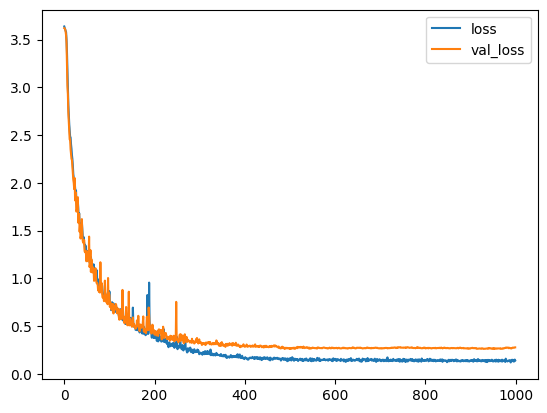

In [19]:
#loss:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show() 

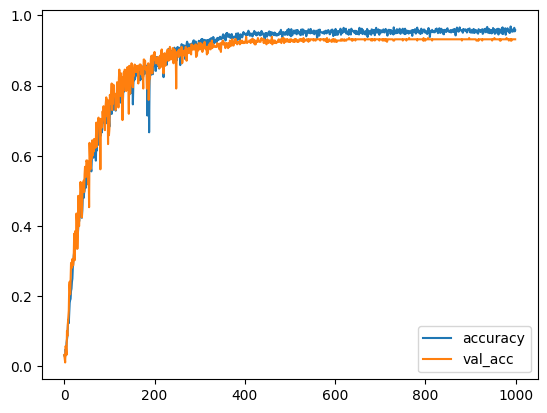

In [20]:
#accuracy:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_acc')
plt.legend()
plt.show() 

In [21]:
LSTM_model.evaluate(test_dataset)

6/6 [==============================] - 0s 35ms/step - loss: 0.2884 - accuracy: 0.9388


[0.2883961498737335, 0.9388489127159119]

In [23]:
LSTM_model.save('models/LSTM_model.h5')

In [ ]:
model = load_model("models/LSTM_model.h5")
actions = np.array(['pizza', 'burger', 'salad', 'soup', 'sphagetti', 'chicken', 'fish', 'vegetables', 'fruits', 'turkey', 'pork', 'hotdog', 'cheese', 'macaroni', 'pepperoni', 'lasagna'])
actions2 = np.array(['sharing', 'platter', 'honey', 'garlic', 'sticks', 'fusion', 'hot', 'fiery', 'ham', 'salt', 'egg', 'basil', 'curry', 'seafood', 'clam', 'mushroom', 'soft', 'crab', 'thai', 'red', 'wings', 'crispy', 'waffle'])
actions = np.concatenate((actions, actions2))

In [28]:
result = model.predict(X_test)
yhat = []
for i in range(len(result)):
    yhat.append(np.argmax(result[i]))
print(multilabel_confusion_matrix(y_test, yhat))
print(accuracy_score(y_test, yhat))

10/10 [==============================] - 0s 22ms/step
[[[287   0]
  [  1   5]]

 [[290   0]
  [  0   3]]

 [[281   1]
  [  0  11]]

 [[288   0]
  [  0   5]]

 [[283   0]
  [  0  10]]

 [[288   0]
  [  2   3]]

 [[288   0]
  [  0   5]]

 [[280   1]
  [  0  12]]

 [[284   1]
  [  0   8]]

 [[290   0]
  [  0   3]]

 [[287   0]
  [  0   6]]

 [[287   0]
  [  0   6]]

 [[284   0]
  [  0   9]]

 [[285   0]
  [  0   8]]

 [[286   0]
  [  0   7]]

 [[282   0]
  [  0  11]]

 [[287   0]
  [  0   6]]

 [[284   0]
  [  0   9]]

 [[288   0]
  [  0   5]]

 [[287   0]
  [  0   6]]

 [[286   0]
  [  0   7]]

 [[285   0]
  [  0   8]]

 [[287   0]
  [  0   6]]

 [[288   0]
  [  0   5]]

 [[282   0]
  [  0  11]]

 [[283   0]
  [  0  10]]

 [[285   0]
  [  0   8]]

 [[283   0]
  [  0  10]]

 [[284   0]
  [  0   9]]

 [[287   0]
  [  0   6]]

 [[288   0]
  [  0   5]]

 [[283   0]
  [  2   8]]

 [[287   0]
  [  0   6]]

 [[284   0]
  [  0   9]]

 [[286   0]
  [  0   7]]

 [[285   0]
  [  0   8]]

 [[284   0